# Prevendo roubo de celulares em SP

## Baixando biblioteca necessária
`pip install xlwt`

`conda install xlwt`

`conda install xlrd`

`conda install plotly`

`conda install matplotlib`

`pip install squarify`

`pip install statsmodels`

`conda install -c conda-forge pygam`

`pip install -U scikit-learn`

### Importando bibliotecas Pandas e Numpy

In [1]:
import pandas as pd
import numpy as np
import glob  
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt               # Visualização de dados
import matplotlib
plt.style.use('fivethirtyeight') 
import squarify
import itertools  
import statsmodels.api as sm
import warnings                               # Ignorar warnings
warnings.filterwarnings("ignore")

In [2]:
# FUNÇÃO PARA IMPORTAR DATASET

dir_path = "data/"

def importaData(files):
    
    data = dir_path + files
    allFiles = glob.glob('data/*.csv')
    list_ = []
    cols = ['ANO_BO', 'DATAOCORRENCIA', 'PERIDOOCORRENCIA', 'BAIRRO', 'CIDADE', 'LATITUDE', 'LONGITUDE', 'LOGRADOURO', \
           'DESCRICAOLOCAL', 'DESCR_TIPO_VEICULO', 'QUANT_CELULAR']

    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, delimiter=';', usecols=cols)
        list_.append(df)

    df = pd.concat(list_, axis = 0, ignore_index = True)
    return df

# IMPORTANDO DATASET

dataset = importaData('*.csv')

In [3]:
# REMOVENDO DADOS DUPLICADOS

def removeDuplicados(df):
    df.drop_duplicates(inplace=True)
    return df

dataset = removeDuplicados(dataset)

In [4]:
# FILTRANDO DADOS DE S.PAULO

def filtraSP(df):
    df.CIDADE.fillna('S.PAULO')
    df = df[df['CIDADE'] == 'S.PAULO']
    del df['CIDADE']
    return df

dataset = filtraSP(dataset)

In [5]:
# TRANSFORMANDO STRINGS PARA LOWER CASE

def lowerCase(df, cols):
    for col in cols:
        df[col] = df[col].str.title()
    return df

colsToLower = ["PERIDOOCORRENCIA", "LOGRADOURO", "BAIRRO", "DESCR_TIPO_VEICULO"]
dataset = lowerCase(dataset, colsToLower)

In [6]:
# PADRONIZANDO STRINGS

def correct_string(string):
        string = string.replace('Avenida ', 'Av. ').replace('Av ', 'Av. ').replace('Rua ', 'R. ').replace('R ', 'R. ') \
                    .replace('R ', 'R. ').replace(',', '.').replace('Praça ', 'Pr. ').replace('Pr ', 'Pr. ').replace('Pública', 'pública')
        return string

dataset.DESCRICAOLOCAL = dataset.astype(str).DESCRICAOLOCAL.apply(correct_string)    
dataset.LOGRADOURO = dataset.astype(str).LOGRADOURO.apply(correct_string)
dataset.LATITUDE = dataset.LATITUDE.astype(str).apply(correct_string).astype(float)
dataset.LONGITUDE = dataset.LONGITUDE.astype(str).apply(correct_string).astype(float)


In [7]:
# TRANSFORMANDO DADOS TEMPORAIS

def tratarDatas(df, col = 'DATAOCORRENCIA'):
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')
    indexs = []
    for row in df[col].items():
        if row[1] < pd.datetime(2010, 1, 1):
            indexs.append(row[0])
    df.drop(index=indexs, axis=1, inplace=True)
    df['diasemana'] = df[col].dt.day_name()
    df['mesano'] = df[col].dt.strftime('%Y-%m')
    df['ano'] = df[col].dt.strftime('%Y')
    df['mes'] = df[col].dt.month
    df.drop(index=df[df['mesano'] == 'NaT'].index, inplace=True, axis=0)
    return df
    
dataset = tratarDatas(dataset)

#### Capturando nome das colunas importantes no dataset

In [11]:
string_gerada=""
for item in dataset.columns:
    string_gerada += "'"+item+"'"+", "
string_gerada

"'ANO_BO', 'DATAOCORRENCIA', 'PERIDOOCORRENCIA', 'LOGRADOURO', 'BAIRRO', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'DESCR_TIPO_VEICULO', 'QUANT_CELULAR', 'diasemana', 'mesano', 'ano', 'mes', "

In [12]:
drop_c = ['ANO_BO', 'NUM_BO', 'BO_INICIADO', 'BO_EMITIDO', 'DATAOCORRENCIA', 'HORAOCORRENCIA', 'PERIDOOCORRENCIA', 'DATACOMUNICACAO', 'DATAELABORACAO', 'BO_AUTORIA', 'FLAGRANTE', 'LOGRADOURO', 'NUMERO', 'BAIRRO', 'CIDADE', 'UF', 'LATITUDE', 'LONGITUDE', 'DESCRICAOLOCAL', 'SOLUCAO', 'DELEGACIA_NOME', 'DELEGACIA_CIRCUNSCRICAO', 'ESPECIE', 'RUBRICA', 'DESDOBRAMENTO', 'STATUS', 'QUANT_CELULAR', 'MARCA_CELULAR']

In [13]:
string_gerada=[]
for item in dataset.columns:
    string_gerada.append(item)
string_gerada

['ANO_BO',
 'DATAOCORRENCIA',
 'PERIDOOCORRENCIA',
 'LOGRADOURO',
 'BAIRRO',
 'LATITUDE',
 'LONGITUDE',
 'DESCRICAOLOCAL',
 'DESCR_TIPO_VEICULO',
 'QUANT_CELULAR',
 'diasemana',
 'mesano',
 'ano',
 'mes']

In [14]:
columns = ['NUMERO_BOLETIM', 'NUMERO_BOLETIM_PRINCIPAL', 'EXAME', 'NOMEPESSOA', 'TIPOPESSOA', 'VITIMAFATAL', 'RG', 'RG_UF', 'NATURALIDADE', 'NACIONALIDADE', 'SEXO', 'DATANASCIMENTO', 'IDADE', 'ESTADOCIVIL', 'PROFISSAO', 'GRAUINSTRUCAO', 'CORCUTIS', 'NATUREZAVINCULADA', 'TIPOVINCULO', 'RELACIONAMENTO', 'PARENTESCO', 'PLACA_VEICULO', 'UF_VEICULO', 'CIDADE_VEICULO', 'DESCR_COR_VEICULO', 'DESCR_MARCA_VEICULO', 'ANO_FABRICACAO', 'ANO_MODELO', 'DESCR_TIPO_VEICULO']

In [15]:
dataset['PERIDOOCORRENCIA'].str.title()

4          De Madrugada
8            Pela Manhã
13           Pela Manhã
24           Pela Manhã
29           Pela Manhã
               ...     
1304697         A Noite
1304699         A Tarde
1304700         A Noite
1304701         A Noite
1304702         A Noite
Name: PERIDOOCORRENCIA, Length: 924651, dtype: object

In [17]:
ocorrencias = dataset.groupby('mesano').count()['ANO_BO'].reset_index()
ocorrencias.rename(columns={'mesano': 'Data', 'ANO_BO':'Ocorrências de Roubo de Celular'}, inplace=True)

trace = [go.Scatter(x = ocorrencias.Data, y = ocorrencias['Ocorrências de Roubo de Celular'])]

layout = dict(
    title='Ocorrências de Roubo de Celular por Mês',
    yaxis=dict(
    title='Ocorrências'
    ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=12,
                     label='1yr',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=trace, layout=layout)
py.iplot(fig)

In [18]:
# CALCULANDO VARIAÇÕES NO NÚMERO DE OCORRÊNCIAS POR ANO

dataset.ANO_BO = dataset.ANO_BO.astype(int)
ocorrencias_ano = dataset.groupby('ANO_BO').count()['DATAOCORRENCIA'].reset_index()
ocorrencias_ano['VARIACAO'] = 0
ocorrencias_ano['VARIACAO_ACUMULADA'] = 0


In [19]:
for i in range (0, 8):
    ocorrencias_ano.iloc[i+1, 2] = round((1 - (ocorrencias_ano.iloc[i, 1] / ocorrencias_ano.iloc[i+1, 1])) * 100, 2)
    ocorrencias_ano.iloc[i+1, 3] = round((ocorrencias_ano.iloc[i, 3] + ocorrencias_ano.iloc[i+1, 2]), 2)
    
ocorrencias_ano.VARIACAO = ocorrencias_ano.VARIACAO.astype(str) + ' %'
ocorrencias_ano.VARIACAO_ACUMULADA = ocorrencias_ano.VARIACAO_ACUMULADA.astype(str) + ' %'

data = [
    go.Bar(
        x = ocorrencias_ano.ANO_BO.values[1:],
        y = ocorrencias_ano.VARIACAO.values[1:],
        marker = dict(
          color = ['green', 'green', 'green', 'green', 'red', 'green', 'red', 'red']
        ),
        name = 'Variação anual'
    ), 
    go.Scatter(
        x = ocorrencias_ano.ANO_BO.values[1:], 
        y = ocorrencias_ano.VARIACAO_ACUMULADA.values[1:],
        marker = dict(
          color = 'blue'
        ),        
        name = 'Variação acumulada'
    )
]

layout = dict(
    title='Variação do Número de Ocorrências de Roubo de Celular',
    yaxis=dict(
        title='Variação (%)',
        ),
    )

fig = dict(data=data, layout=layout)
py.iplot(fig)

In [20]:
dataset['diasemana'] = pd.Categorical(dataset['diasemana'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

trace = [go.Bar(
            x = dataset['diasemana'].value_counts().sort_index().index,
            y = dataset['diasemana'].value_counts().sort_index().values,
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Ocorrências de Roubo de Celular por Dia da Semana (2020)',
    yaxis=dict(
        title='Ocorrências'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

In [21]:
colors = ['#170B3B', '#A9D0F5', '#08088A', '#DBA901']

trace = [go.Pie(labels=dataset.PERIDOOCORRENCIA.unique(), values=dataset.PERIDOOCORRENCIA.value_counts().values,
               hoverinfo='label+percent', 
               textfont=dict(size=18),
               marker=dict(colors=colors, 
                           line=dict(color='#000000', width=2)))]

layout = go.Layout(
    title='Período das Ocorrências de Roubo de Celular (2010-2018)'
)

fig = go.Figure(data = trace, layout = layout)

py.iplot(fig)

In [22]:
# FILTRANDO DADOS DE 2018

data = dataset[dataset["ANO_BO"] == 2018].copy()

# PLOT

trace = [go.Bar(
            y = data['DESCRICAOLOCAL'].value_counts().index,
            x = data['DESCRICAOLOCAL'].value_counts().values,
            orientation='h',
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    height=800,
    title='Locais das Ocorrências de Roubo de Celular em 2018',
    xaxis=dict(
        title = 'Ocorrências',
        type='log',
        ),
     yaxis=go.layout.YAxis(
     automargin=True
     )
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

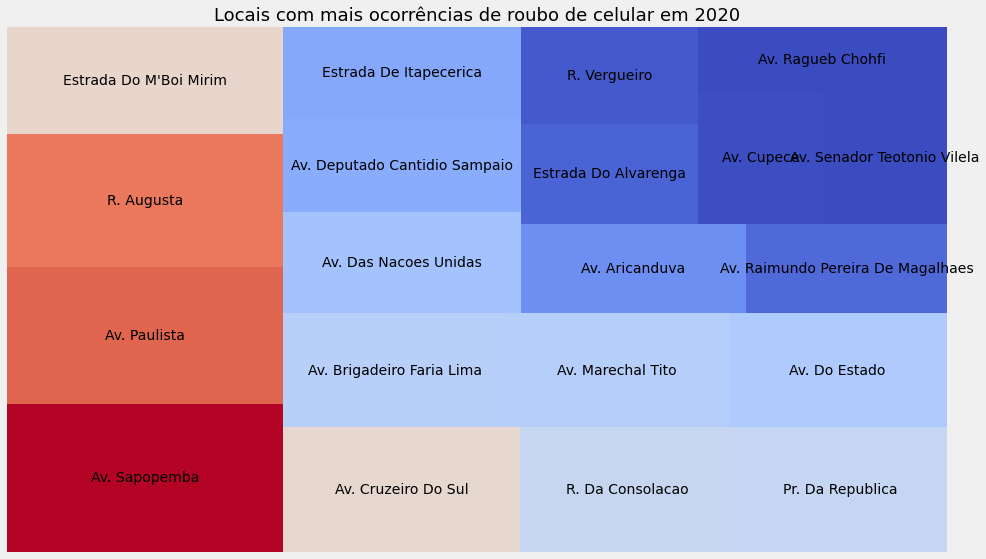

In [23]:
fig, ax = plt.subplots(figsize=(15,9))

cmap = matplotlib.cm.coolwarm
mini = data.LOGRADOURO.value_counts().values[19]
maxi = data.LOGRADOURO.value_counts().values[0]
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in data.LOGRADOURO.value_counts().iloc[:100].values]

squarify.plot(sizes=data.LOGRADOURO.value_counts().iloc[:20].values, label=data.LOGRADOURO.value_counts().iloc[:20].index, color=colors)

plt.axis('off')
plt.title("Locais com mais ocorrências de roubo de celular em 2020", fontsize=18)
ttl = ax.title
ttl.set_position([.5, 1.05])

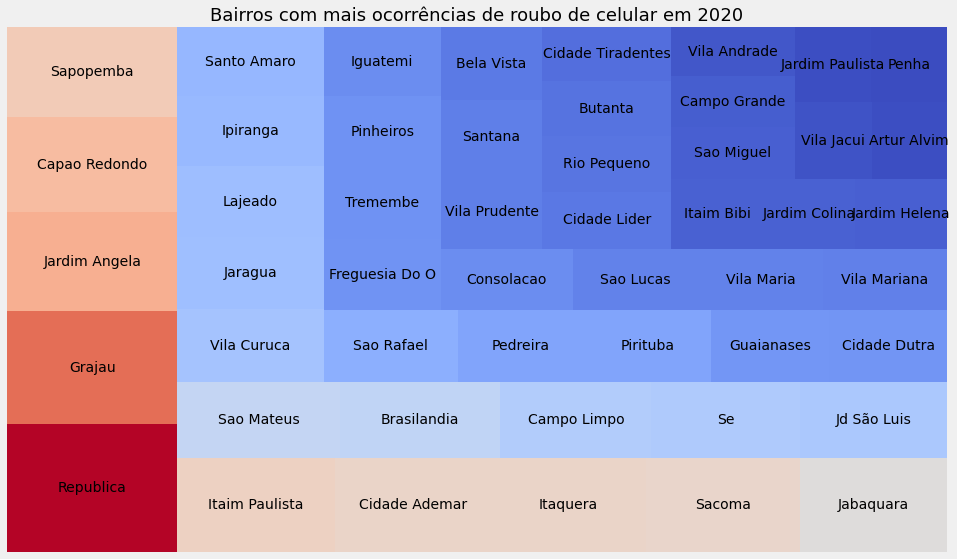

In [24]:
fig, ax = plt.subplots(figsize=(15,9))

cmap = matplotlib.cm.coolwarm
mini = data.BAIRRO.value_counts().values[49]
maxi = data.BAIRRO.value_counts().values[0]
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in data.BAIRRO.value_counts().iloc[:100].values]

squarify.plot(sizes=data.BAIRRO.value_counts().iloc[:50].values, label=data.BAIRRO.value_counts().iloc[:50].index, color=colors)

plt.axis('off')
plt.title("Bairros com mais ocorrências de roubo de celular em 2020", fontsize=18)
ttl = ax.title
ttl.set_position([.5, 1.05])

In [25]:
# FILTRANDO DADOS DE 2018

data = dataset.copy()

# PLOT

trace = [go.Bar(
            y = data['DESCR_TIPO_VEICULO'].value_counts().index,
            x = data['DESCR_TIPO_VEICULO'].value_counts().values,
            orientation='h',
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    height=800,
    title='Veículos mais visados pelos ladrões para roubar um celular(2010-2018)',
    xaxis=dict(
        title = 'Ocorrências',
        type='log',
        ),
     yaxis=go.layout.YAxis(
     automargin=True
     )
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

In [26]:
dataset['ano'] = pd.Categorical(dataset['ano'], categories=['2010','2011','2012','2013','2014','2015', '2016', '2017', '2018'], ordered=True)

trace = [go.Bar(
            x = dataset['ano'].value_counts().sort_index().index,
            y = dataset['QUANT_CELULAR'].value_counts(),
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Ocorrências de Roubo de Celular por Dia da Semana (2020)',
    yaxis=dict(
        title='Ocorrências'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

In [28]:
qnt_ano = dataset.groupby('ANO_BO').count()['QUANT_CELULAR'].reset_index()

In [30]:
trace = [go.Bar(
            x = qnt_ano['ANO_BO'],
            y = qnt_ano['QUANT_CELULAR'],
            textposition = 'auto',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1,
                    )
                ),
            opacity=0.8
)]
           
layout = go.Layout(
    title='Quantidade de celulares roubados (2010-2018)',
    yaxis=dict(
        title='Qnt. cel'
        ),
)

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig)

# Série Estacionária

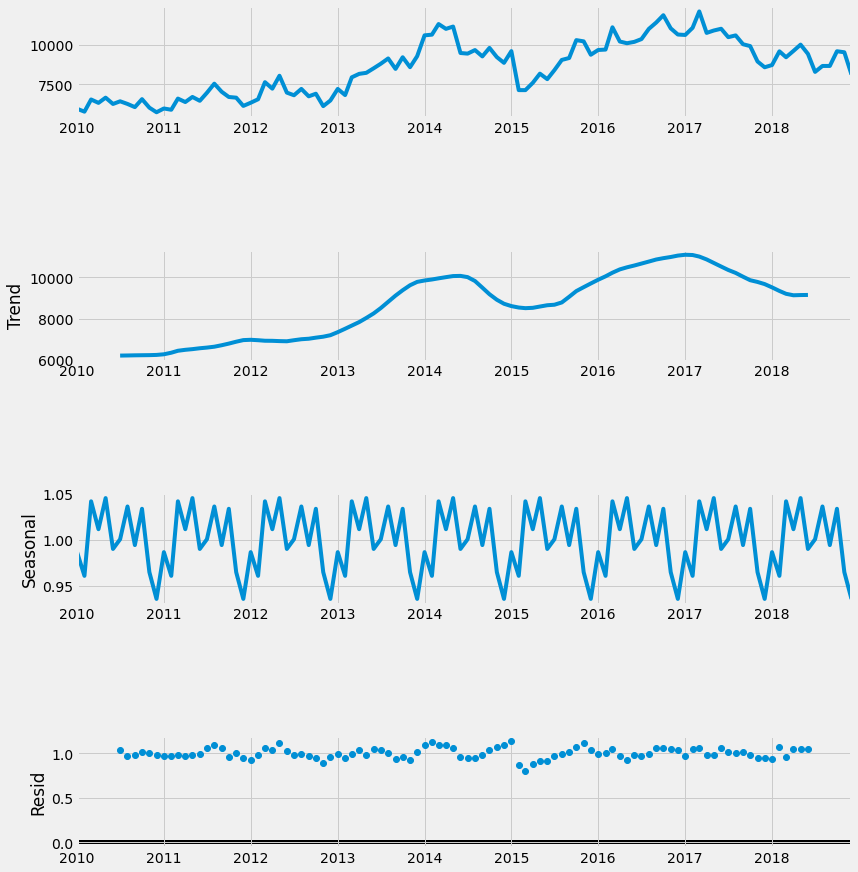

In [31]:
# TRANSFORMANDO SÉRIE TEMPORAL

ocorrencias.index =  ocorrencias.Data
ocorrencias.drop(columns='Data', inplace=True)
ocorrencias.index = pd.to_datetime(ocorrencias.index)

# IMPORTANDO BIBLIOTECAS

#from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose

# DECOMPOSIÇÃO DA SÉRIE TEMPORAL

result = seasonal_decompose(ocorrencias, model='multiplicative')
g = result.plot()
g.set_figwidth(14)
g.set_figheight(14)

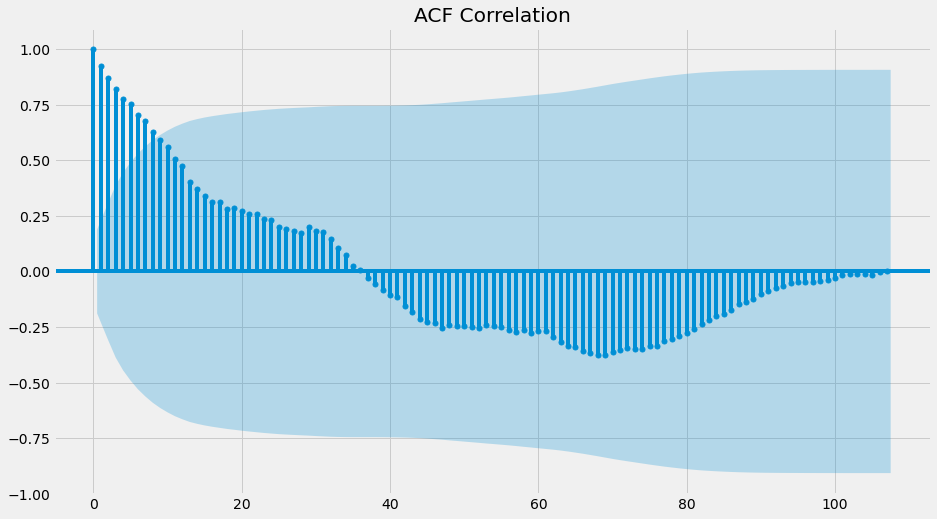

In [32]:
# IMPORTANDO BIBLIOTECAS

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# PLOT DE CORRELAÇÃO ACF

g = plot_acf(ocorrencias, title="ACF Correlation", lags=(len(ocorrencias)-1))
g.set_figheight(8)
g.set_figwidth(14)

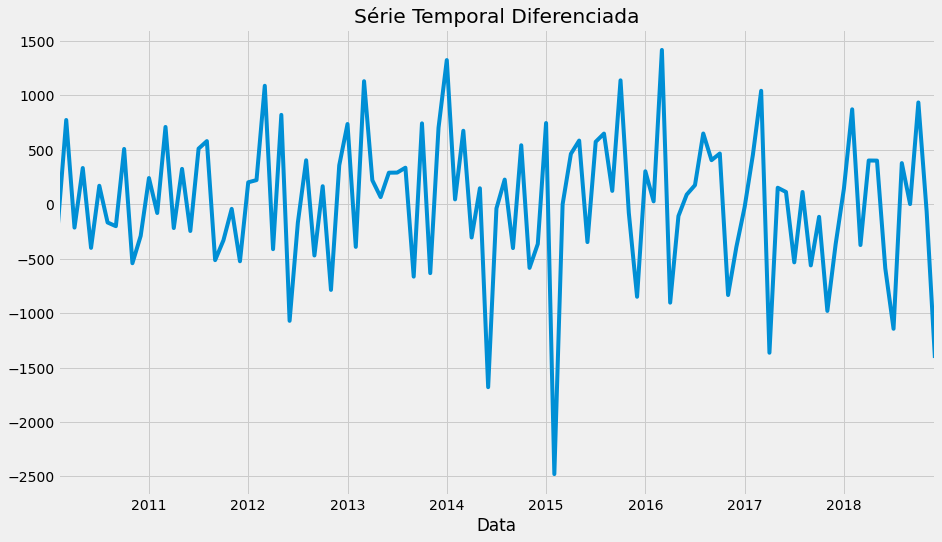

In [33]:
# DIFERENCIANDO SÉRIE TEMPORAL

ocorrencias_diff = ocorrencias.diff(periods=1)
ocorrencias_diff = ocorrencias_diff[1:]

# PLOT DA SÉRIE TEMPORAL DIFERENCIADA COM D = 1

g = ocorrencias_diff.plot(figsize=(14,8), title="Série Temporal Diferenciada", legend=False)

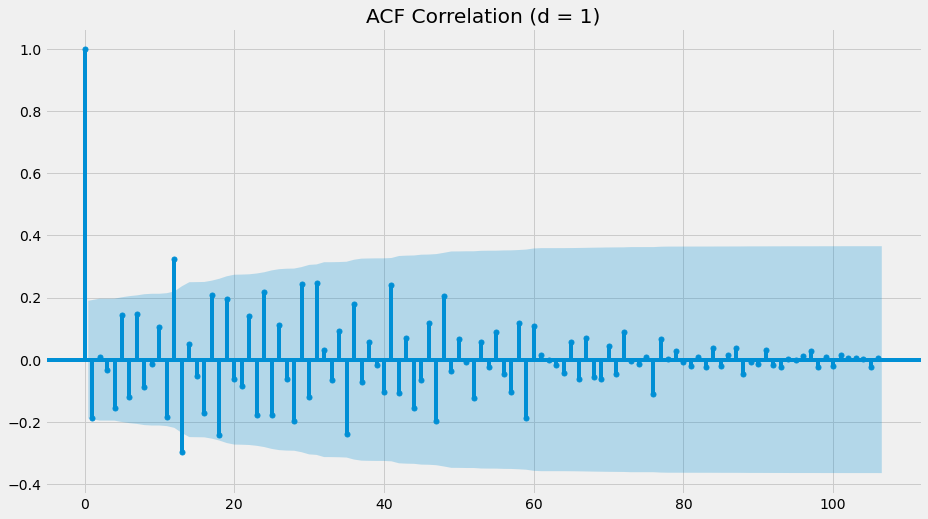

In [34]:
# PLOT CORRELAÇÃO ACF

g = plot_acf(ocorrencias_diff, title="ACF Correlation (d = 1)", lags=(len(ocorrencias)-2))
g.set_figheight(8)
g.set_figwidth(14)

Melhoers parâmetros:  ((3, 1, 13), (3, 1, 0, 12))  AUC:  913.5922228003983


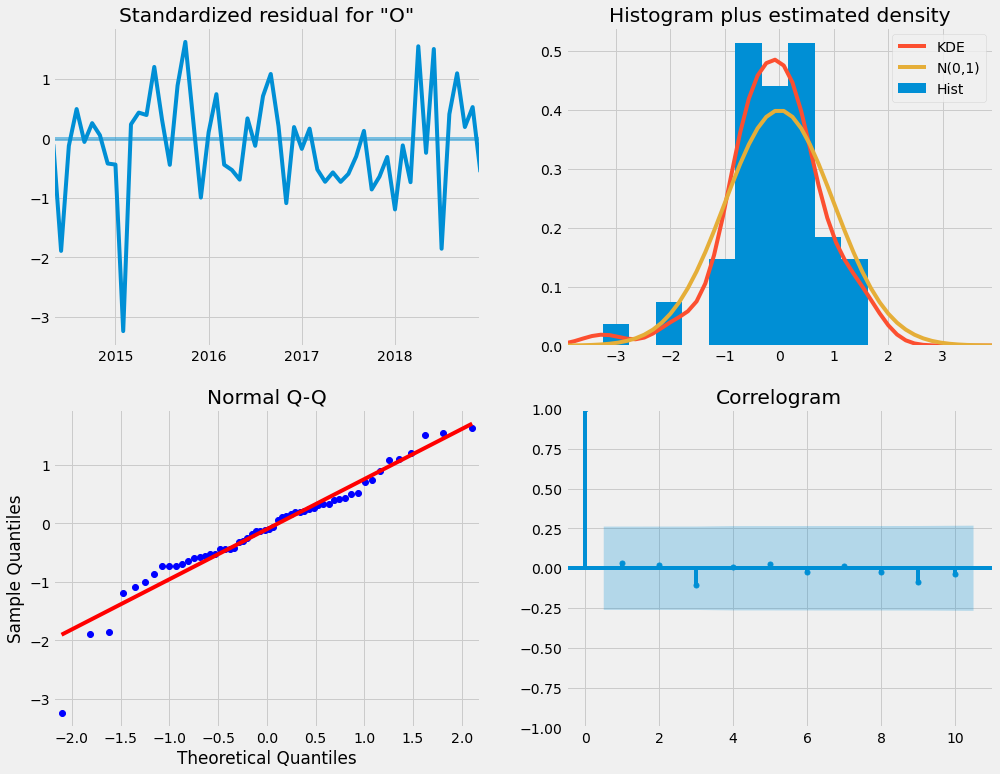

In [35]:
# DEFINE COMBINAÇÕES ENTRE p DE 0 A 3, d = 1, e q = 13
pdq = [(p, 1, 13) for p in range(0, 4)]

# DEFINE P e Q ENTRE 0 e 3
P = Q = range(0, 4)

# DEFINE COMBINAÇÕES ENTRE P, D e Q
seasonal_pdq = [(x[0], 1, x[1], 12) for x in list(itertools.product(P, Q))]

# CALCULANDO O MELHOR PARÂMETRO PARA O MODELO

scores = {}

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ocorrencias,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            scores[param, param_seasonal] = results.aic
            
        except:
            continue
            
print("Melhoers parâmetros: ", min(scores, key=scores.get)," AUC: ", min(scores.values()))

# CRIANDO MODELO COM OS MELHOERS PARÂMETROS 

mod = sm.tsa.statespace.SARIMAX(ocorrencias,
                                order=(3, 1, 13),
                                seasonal_order=(3, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

# RESUMO DO MODELO

results.plot_diagnostics(figsize=(15, 12))
plt.show()

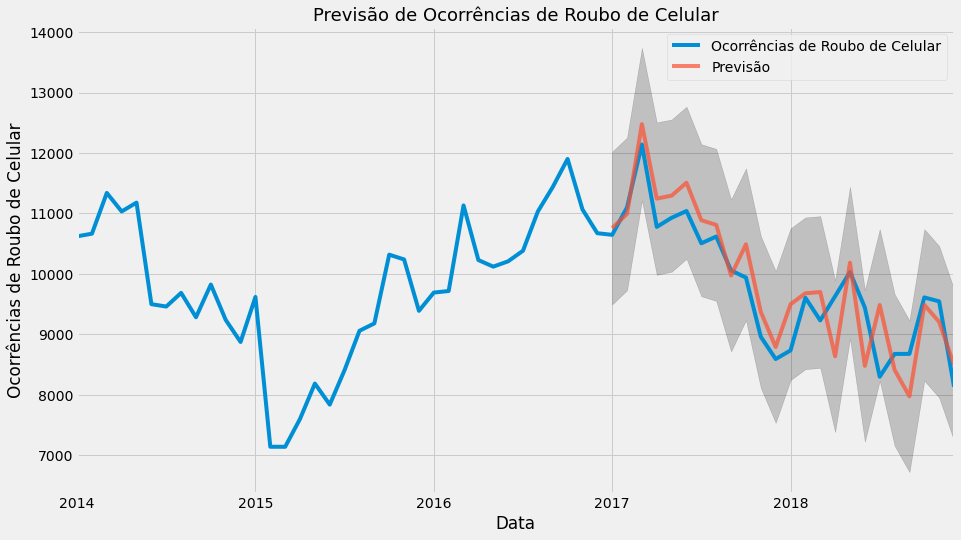

In [36]:
# VALIDAÇÃO DO MODELO: PREVENDO OCORRÊNCIAS A PARTIR DE 2017

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = ocorrencias['2014':].plot(figsize=(14, 8))
pred.predicted_mean.plot(ax=ax, label='Previsão', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_title("Previsão de Ocorrências de Roubo de Celular", fontsize=18)
ax.set_xlabel('Data')
ax.set_ylabel('Ocorrências de Roubo de Celular')
plt.legend()

plt.show()

In [37]:
# CALCULANDO MSE

y_forecasted = pred.predicted_mean
y_truth = ocorrencias["2017-01-01":].squeeze()

mse = ((y_forecasted - y_truth) ** 2).mean()

print('O Mean Squared Error da previsão foi {}'.format(round(mse)))

O Mean Squared Error da previsão foi 266279


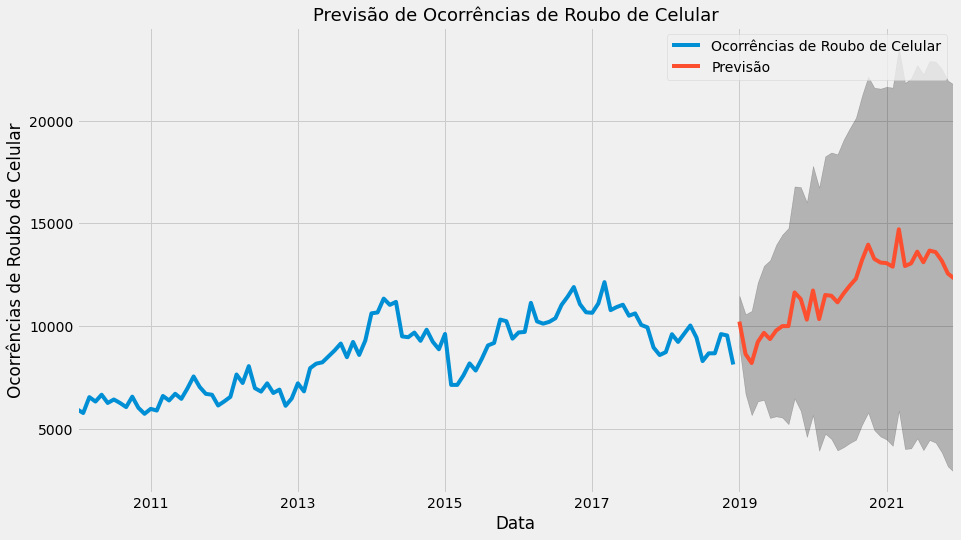

In [38]:
# PREVENDO OCORRÊNCIAS PARA OS PRÓXIMOS TRÊS ANOS

pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()

ax = ocorrencias['2010':].plot(figsize=(14, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Previsão')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_title("Previsão de Ocorrências de Roubo de Celular", fontsize=18)
ax.set_xlabel('Data')
ax.set_ylabel('Ocorrências de Roubo de Celular')

plt.legend()
plt.show()

# GAM

In [39]:
import feather
from pygam import LinearGAM
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [40]:
ocorrencias.dropna()

Ocorrências de Roubo de Celular
Data                                       
2010-01-01                             5956
2010-02-01                             5772
2010-03-01                             6545
2010-04-01                             6330
2010-05-01                             6662
...                                     ...
2018-08-01                             8676
2018-09-01                             8677
2018-10-01                             9611
2018-11-01                             9545
2018-12-01                             8133

[108 rows x 1 columns]

In [41]:
ocorrencias = dataset.groupby(['mesano','ano','mes']).count()['ANO_BO'].reset_index().dropna()
ocorrencias.rename(columns={'ano': 'Data', 'ANO_BO':'Ocorrências de Roubo de Celular'}, inplace=True)

In [42]:
year_map = {'2010':1, '2011':2, '2012':3, '2013':4, '2014':5, '2015':6, '2016':7, '2017':8,'2018':9}
ocorrencias2 = ocorrencias
ocorrencias2['Data'] = ocorrencias2['Data'].map(year_map)

<AxesSubplot:xlabel='mesano'>

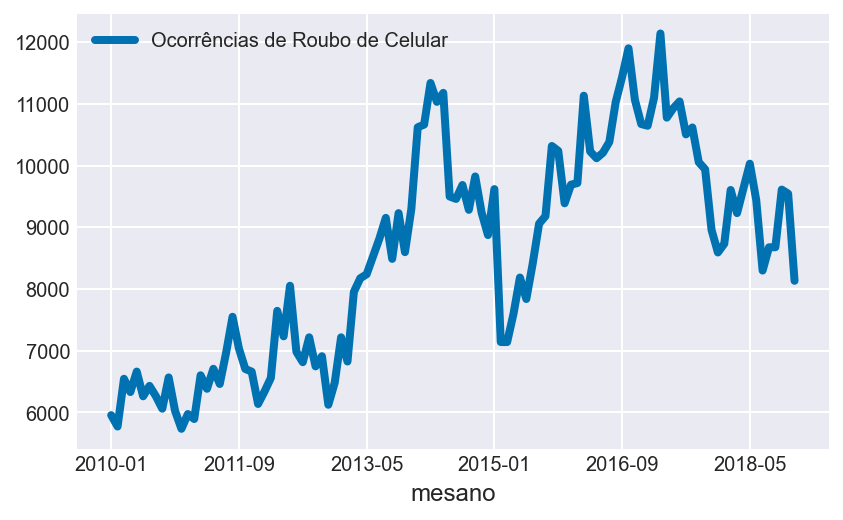

In [43]:
ocorrencias2.plot(x='mesano', y='Ocorrências de Roubo de Celular')

In [44]:
zQntRoubos = np.array(ocorrencias2['Ocorrências de Roubo de Celular'])
zDatas = np.array(ocorrencias2[['mes','Data']])

In [102]:
gam = LinearGAM(n_splines=20).gridsearch(zDatas, zQntRoubos)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


<Figure size 432x288 with 0 Axes>

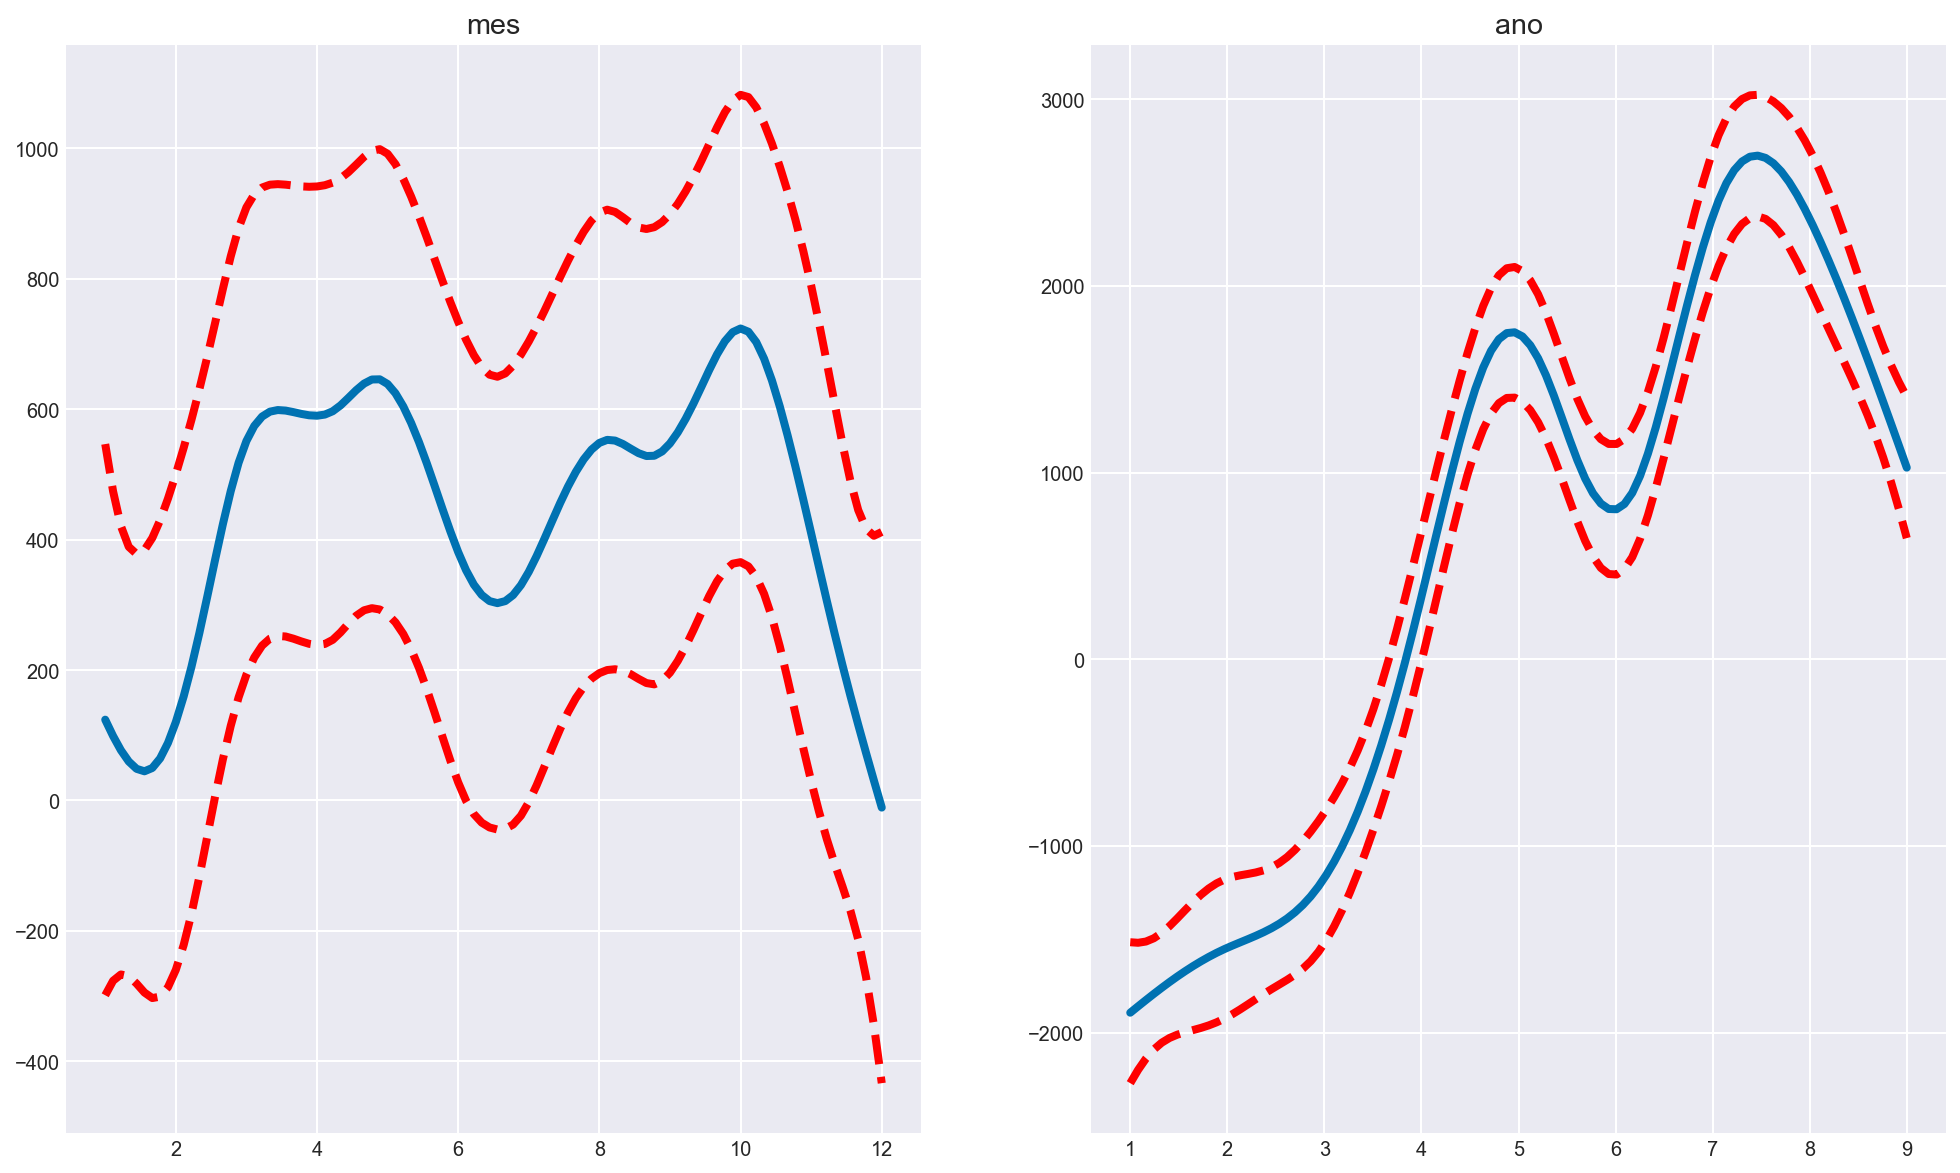

In [103]:
## plotting
plt.figure();
fig, axs = plt.subplots(1,2);
fig.set_figheight(10)
fig.set_figwidth(15)

titles = ['mes', 'ano']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);

In [92]:
predictions = gam.predict(ocorrencias2[['mes', 'Data']])

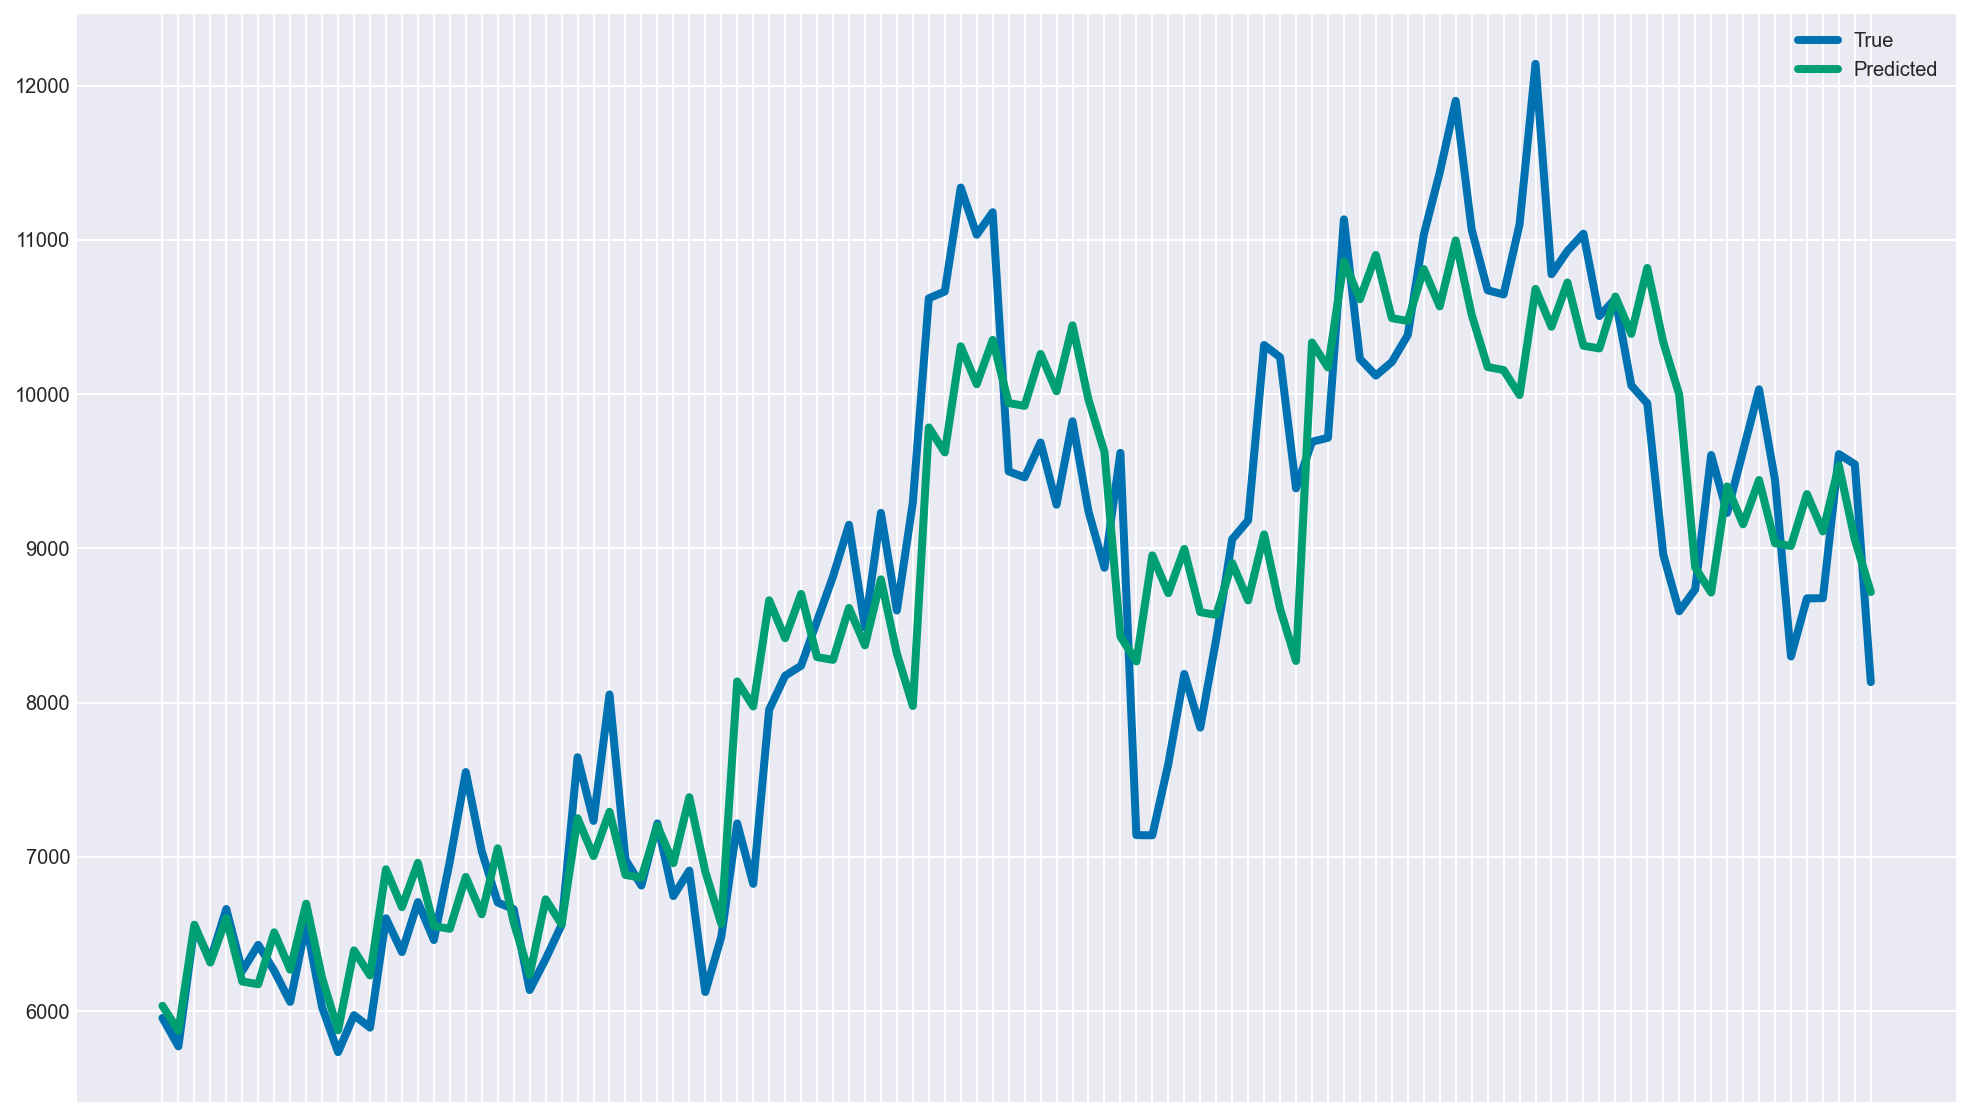

In [93]:
fig = plt.figure(figsize=(15, 10))
plt.plot(ocorrencias2['mesano'], ocorrencias2['Ocorrências de Roubo de Celular'])
plt.plot(ocorrencias2['mesano'], predictions)
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,         
    labelbottom=False) 
plt.legend(['True', 'Predicted'])

In [97]:
from sklearn.metrics import mean_squared_error
print('O Mean Squared Error da previsão foi {}'.format(round(mean_squared_error(ocorrencias2['Ocorrências de Roubo de Celular'], predictions))))

O Mean Squared Error da previsão foi 432596


In [98]:
futuro = ocorrencias2.copy()

In [99]:
indice = 11664
kyear = 19
for k in range(0,3):
    for i in range (0, 12):
        if(i+1<10):
            mes='0'+str(i+1)
        else:
            mes = str(i+1)
        futuro.loc[indice] = list(['20'+str(kyear)+'-'+mes, 10+k, (i+1) * 1.0,0])
        indice = indice + 1
    kyear = kyear + 1

In [100]:
predictions = gam.predict(futuro[['mes', 'Data']])

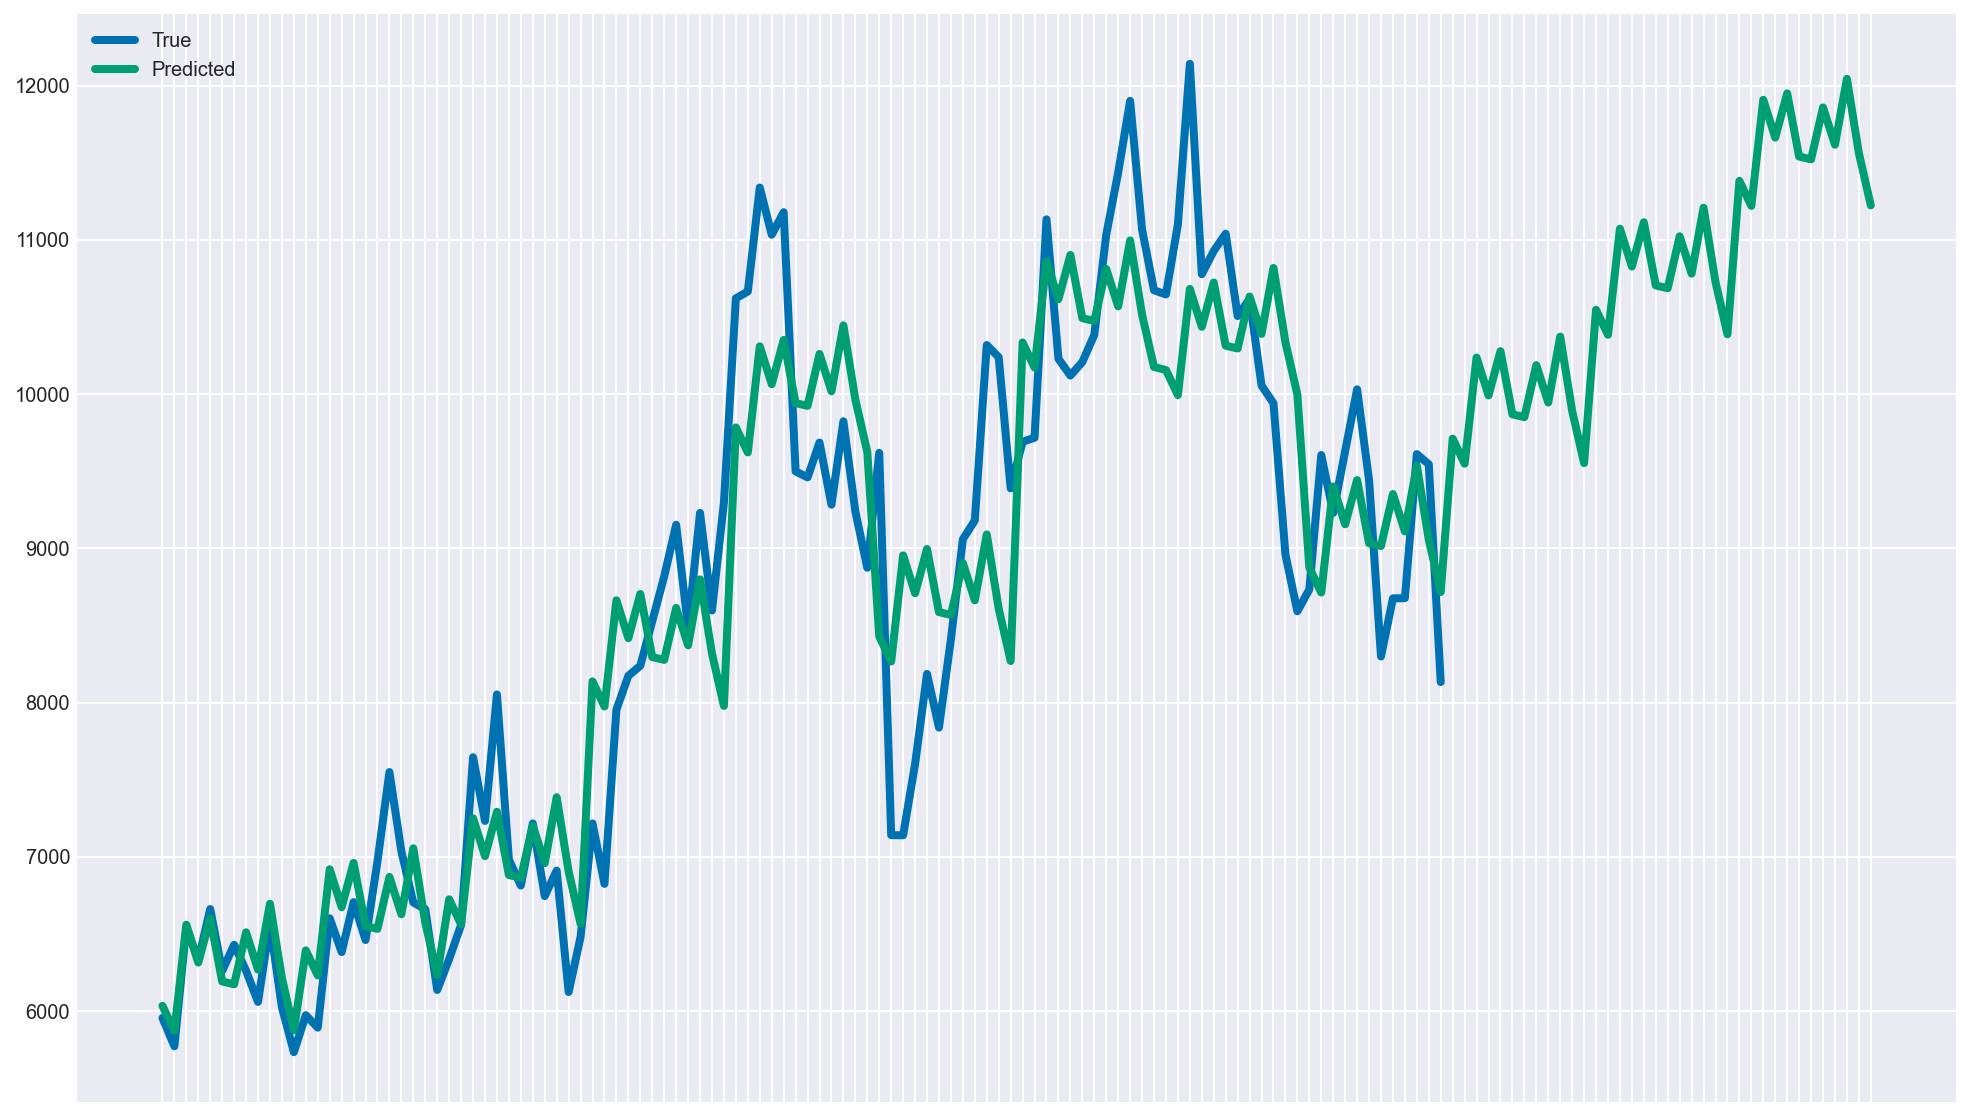

In [101]:
fig = plt.figure(figsize=(15, 10))
plt.plot(ocorrencias2['mesano'], ocorrencias2['Ocorrências de Roubo de Celular'])
plt.plot(futuro['mesano'], predictions)
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=False,     
    top=False,         
    labelbottom=False)
plt.legend(['True', 'Predicted'])